In [8]:
from rasterio.windows import Window
import pandas as pd

from dataset import (
    get_dataset, 
    save_map, 
    save_pred_map_to_tif
)

In [15]:
path_S2B = './data/tile_UTM38N/20180730'

In [16]:
channels = ['volume', 'age', 'basal_area', 'carbon_stock', 'height', 'type']

In [17]:
# Get table with types and ages
y0, x0 = 6000, 0
window_n = Window.from_slices((y0, y0 + 4000), (x0, x0 + 2700))

y0, x0 = 0, 5700
window_r = Window.from_slices((y0, y0 + 7000), (x0, x0 + 10000))


### Test
y0, x0 = 7500, 2700
window_k = Window.from_slices((y0, y0 + 3000), (x0, x0 + 1200))

In [18]:
def stack_several_dates_dataset(path_S2B_list, 
                              target, 
                              channels_list=['B02'], 
                              window=None, 
                              indices=False):
    dataset_list = []
    ch_list = channels_list + [target]

    for path_S2B in path_S2B_list:
        dataset = get_dataset(
            path_S2B, 
            channels_list=ch_list, 
            window=window, 
            visualise=False, 
            indices=indices)
        
        dataset = dataset[dataset[target] > 0]
       
        dataset_list.append(dataset)

    dataset = pd.concat(dataset_list)
        
    return dataset

In [38]:
train_dataset = pd.concat([
    stack_several_dates_dataset([path_S2B], 'age', channels_list=channels, window=window_n, indices=False),
    stack_several_dates_dataset([path_S2B], 'age', channels_list=channels, window=window_r, indices=False),
])

test_dataset = stack_several_dates_dataset([path_S2B], 'age', channels_list=channels, window=window_k, indices=False)

<AxesSubplot: >

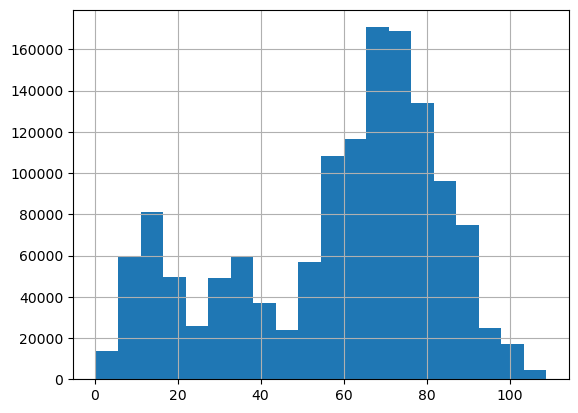

In [41]:
test_dataset['carbon_stock'].hist(bins=20)

In [155]:
def calculate_areas_distribution(dataset, 
                                 column='carbon_stock', 
                                 bins_range=(0, 150), 
                                 bins_freq=10):
    # create intervals
    bins = pd.interval_range(*bins_range, freq=bins_freq)

    # assign each value in df["column"] to bin and count bin occurences
    counts = pd.cut(dataset[column], bins).value_counts()
    km2 = counts * 100 / 1_000_000

    # create a DataFrame, indexed by interval midpoints
    df = pd.DataFrame(km2[bins], index=bins.mid)
    return df, bins

# Carbon stock

In [233]:
cmin=0
cmax=150
csize=10

df_train, bins = calculate_areas_distribution(
    train_dataset, 
    column='carbon_stock', 
    bins_range=(cmin, cmax), 
    bins_freq=csize
)

df_test, bins = calculate_areas_distribution(
    test_dataset, 
    column='carbon_stock', 
    bins_range=(cmin, cmax), 
    bins_freq=csize
)

colors_carbonstock_greens_0_150 = ["#eef8ea", "#e4f5df", "#d5efcf",
                                   "#c5e8be", "#b2e0ab", "#9ed798", 
                                   "#86cd85", "#6fc173", "#55b567",
                                   "#3da75a", "#2e964e", "#1d8641",
                                   "#0a7533", "#005f26", "#00441b",]
ticks = [str(i_bin.left)+' - '+str(i_bin.right) for i_bin in bins]

## №1.
в этом варианте цвета в каждом столбике соответствуют цветам из карты

In [169]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=df_train.index,
        y=df_train['count'], 
        histfunc="sum",
        xbins=dict(start=cmin, end=cmax, size=csize),
        name='Train set',
        marker=dict(
            cmin=cmin, 
            cmax=cmax, 
            color=colors_carbonstock_greens_0_150,
        ),
    )
)

fig.add_trace(
    go.Histogram(
        x=df_test.index,
        y=df_test['count'], 
        histfunc="sum",
        name='Test set',
        xbins=dict(start=cmin, end=cmax, size=csize),
        marker=dict(
            cmin=cmin, 
            cmax=cmax,  
            color=colors_carbonstock_greens_0_150,
            # pattern_shape='+',
            # pattern_size=0.1,
        ),
    )
)


fig.update_layout(
    #barmode='overlay', 
    template='simple_white',
    # xaxis = dict(tickmode = 'linear', tick0=cmin, dtick=csize,),
    xaxis = dict(tickmode = 'array',
                 tickvals = df_train.index.tolist(),
                 ticktext = ticks),
    
    xaxis_title_text=r'$\text{Carbon stock} \left[\frac{\text{t C}}{\text{ha}}\right]$',
    yaxis_title_text=r'$\text{km}^2$', 
    xaxis_tickangle=45,
    yaxis_gridwidth=0.01,
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.01, # gap between bars of the same location coordinates
    height=600, 
    width=600,
    
)
fig.write_image(f"plots/carbon_stock_train_test_bins_areas.pdf")

## №2.
в этом варианте только два цвета

In [234]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=df_train.index,
        y=df_train['count'], 
        histfunc="sum",
        xbins=dict(start=cmin, end=cmax, size=csize),
        name='Train set',
        marker=dict(
            cmin=cmin, 
            cmax=cmax, 
            color="#2e964e",
        ),
    )
)

fig.add_trace(
    go.Histogram(
        x=df_test.index,
        y=df_test['count'], 
        histfunc="sum",
        name='Test set',
        xbins=dict(start=cmin, end=cmax, size=csize),
        marker=dict(
            cmin=cmin, 
            cmax=cmax,  
            color="#6fc173",
        ),
    )
)


fig.update_layout(
    #barmode='overlay', 
    template='none',
    # xaxis = dict(tickmode = 'linear', tick0=cmin, dtick=csize,),
    xaxis = dict(tickmode = 'array',
                 tickvals = df_train.index.tolist(),
                 ticktext = ticks),
    
    xaxis_title_text=r'$\text{Carbon stock} \left[\frac{\text{t C}}{\text{ha}}\right]$',
    yaxis_title_text=r'$\text{Total area } \left[\text{km}^2\right]$', 
    xaxis_tickangle=45,
    yaxis_gridwidth=0.01,
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.01, # gap between bars of the same location coordinates
    height=600, 
    width=600,
    
)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.9
))
fig.write_image(f"plots/carbon_stock_train_test_bins_areas_2colors.pdf")

# Age

In [235]:
cmin=0
cmax=150
csize=15

df_train, bins = calculate_areas_distribution(
    train_dataset, 
    column='age', 
    bins_range=(cmin, cmax), 
    bins_freq=csize
)

df_test, bins = calculate_areas_distribution(
    test_dataset, 
    column='age', 
    bins_range=(cmin, cmax), 
    bins_freq=csize
)

colors_age_pink_0_135 = ["#f1eef6", "#e5d5e9", "#dabbdb",
                           "#da9acb", "#dd77b9", "#df55a3", 
                           "#de348a", "#d51971", "#b70c5a",
                           "#980043",
                          ]
ticks = [str(i_bin.left)+' - '+str(i_bin.right) for i_bin in bins]

In [236]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=df_train.index,
        y=df_train['count'], 
        histfunc="sum",
        xbins=dict(start=cmin, end=cmax, size=csize),
        name='Train set',
        marker=dict(
            cmin=cmin, 
            cmax=cmax, 
            color="#d51971",
        ),
    )
)

fig.add_trace(
    go.Histogram(
        x=df_test.index,
        y=df_test['count'], 
        histfunc="sum",
        name='Test set',
        xbins=dict(start=cmin, end=cmax, size=csize),
        marker=dict(
            cmin=cmin, 
            cmax=cmax,  
            color="#da9acb",
        ),
    )
)


fig.update_layout(
    #barmode='overlay', 
    template='none',
    # xaxis = dict(tickmode = 'linear', tick0=cmin, dtick=csize,),
    xaxis = dict(tickmode = 'array',
                 tickvals = df_train.index.tolist(),
                 ticktext = ticks),
    
    xaxis_title_text=r'$\text{Age} \left[\text{yrs}\right]$',
    yaxis_title_text=r'$\text{Total area } \left[\text{km}^2\right]$',  
    xaxis_tickangle=45,
    yaxis_gridwidth=0.01,
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.01, # gap between bars of the same location coordinates
    height=600, 
    width=600,
    
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.9
))


fig.write_image(f"plots/age_train_test_bins_areas_2colors.pdf")

# Height

In [237]:
cmin=0
cmax=30
csize=2

df_train, bins = calculate_areas_distribution(
    train_dataset, 
    column='height', 
    bins_range=(cmin, cmax), 
    bins_freq=csize
)

df_test, bins = calculate_areas_distribution(
    test_dataset, 
    column='height', 
    bins_range=(cmin, cmax), 
    bins_freq=csize
)

colors_height_purples_0_30 = ["#fcfbfd","#f5f3f9","#edebf4",
                              "#e1e1ef","#d4d4e8","#c4c4e0",
                              "#b3b3d6","#a39fcb","#928fc2",
                              "#827fbb","#7261ab","#65479e",
                              "#5a3395","#4e1c8a","#3f007d",]

ticks = [str(i_bin.left)+' - '+str(i_bin.right) for i_bin in bins]

In [238]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=df_train.index,
        y=df_train['count'], 
        histfunc="sum",
        xbins=dict(start=cmin, end=cmax, size=csize),
        name='Train set',
        marker=dict(
            cmin=cmin, 
            cmax=cmax, 
            color="#65479e",
        ),
    )
)

fig.add_trace(
    go.Histogram(
        x=df_test.index,
        y=df_test['count'], 
        histfunc="sum",
        name='Test set',
        xbins=dict(start=cmin, end=cmax, size=csize),
        marker=dict(
            cmin=cmin, 
            cmax=cmax,  
            color="#928fc2",
        ),
    )
)


fig.update_layout(
    #barmode='overlay', 
    template='none',
    # xaxis = dict(tickmode = 'linear', tick0=cmin, dtick=csize,),
    xaxis = dict(tickmode = 'array',
                 tickvals = df_train.index.tolist(),
                 ticktext = ticks),
    
    xaxis_title_text=r'$\text{Height} \left[\text{m}\right]$',
    yaxis_title_text=r'$\text{Total area } \left[\text{km}^2\right]$', 
    xaxis_tickangle=45,
    yaxis_gridwidth=0.01,
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.01, # gap between bars of the same location coordinates
    height=600, 
    width=600,
    
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.9
))


fig.write_image(f"plots/height_train_test_bins_areas_2colors.pdf")

# Basal area

In [239]:
cmin=0
cmax=24
csize=2

df_train, bins = calculate_areas_distribution(
    train_dataset, 
    column='basal_area', 
    bins_range=(cmin, cmax), 
    bins_freq=csize
)

df_test, bins = calculate_areas_distribution(
    test_dataset, 
    column='basal_area', 
    bins_range=(cmin, cmax), 
    bins_freq=csize
)

colors_basalarea_blues_0_24 = ["#e7f1fa","#d7e6f5","#c8dcf0",
                               "#afd1e7","#94c4df","#73b2d8",
                               "#57a0ce","#3e8ec4","#2979b9",
                               "#1663aa","#084c94","#08306b",]
            
ticks = [str(i_bin.left)+' - '+str(i_bin.right) for i_bin in bins]

In [240]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=df_train.index,
        y=df_train['count'], 
        histfunc="sum",
        xbins=dict(start=cmin, end=cmax, size=csize),
        name='Train set',
        marker=dict(
            cmin=cmin, 
            cmax=cmax, 
            color="#2979b9",
        ),
    )
)

fig.add_trace(
    go.Histogram(
        x=df_test.index,
        y=df_test['count'], 
        histfunc="sum",
        name='Test set',
        xbins=dict(start=cmin, end=cmax, size=csize),
        marker=dict(
            cmin=cmin, 
            cmax=cmax,  
            color="#73b2d8",
        ),
    )
)


fig.update_layout(
    #barmode='overlay', 
    template='none',
    # xaxis = dict(tickmode = 'linear', tick0=cmin, dtick=csize,),
    xaxis = dict(tickmode = 'array',
                 tickvals = df_train.index.tolist(),
                 ticktext = ticks),
    
    xaxis_title_text=r'$\text{Basal area} \left[\frac{\text{m}^2}{\text{ha}}\right]$',
    yaxis_title_text=r'$\text{Total area } \left[\text{km}^2\right]$',  
    xaxis_tickangle=45,
    yaxis_gridwidth=0.01,
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.01, # gap between bars of the same location coordinates
    height=600, 
    width=600,
    
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.9
))


fig.write_image(f"plots/basal_area_train_test_bins_areas_2colors.pdf")

# Volume

In [241]:
cmin=0
cmax=450
csize=50

df_train, bins = calculate_areas_distribution(
    train_dataset, 
    column='volume', 
    bins_range=(cmin, cmax), 
    bins_freq=csize
)

df_test, bins = calculate_areas_distribution(
    test_dataset, 
    column='volume', 
    bins_range=(cmin, cmax), 
    bins_freq=csize
)

colors_volume_oranges_0_500 = ["#fff5eb", "#fee8d2", "#fdd6af",
                               "#fdbd83", "#fda057", "#fa8331",
                               "#ee6511", "#d94901", "#ab3803", "#7f2704",]
            
ticks = [str(i_bin.left)+' - '+str(i_bin.right) for i_bin in bins]

In [242]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=df_train.index,
        y=df_train['count'], 
        histfunc="sum",
        xbins=dict(start=cmin, end=cmax, size=csize),
        name='Train set',
        marker=dict(
            cmin=cmin, 
            cmax=cmax, 
            color="#ee6511",
        ),
    )
)

fig.add_trace(
    go.Histogram(
        x=df_test.index,
        y=df_test['count'], 
        histfunc="sum",
        name='Test set',
        xbins=dict(start=cmin, end=cmax, size=csize),
        marker=dict(
            cmin=cmin, 
            cmax=cmax,  
            color="#fda057",
        ),
    )
)


fig.update_layout(
    #barmode='overlay', 
    template='none',
    # xaxis = dict(tickmode = 'linear', tick0=cmin, dtick=csize,),
    xaxis = dict(tickmode = 'array',
                 tickvals = df_train.index.tolist(),
                 ticktext = ticks),
    
    xaxis_title_text=r'$\text{Timber stock} \left[\frac{\text{m}^3}{\text{ha}}\right]$',
    yaxis_title_text=r'$\text{Total area } \left[\text{km}^2\right]$',  
    xaxis_tickangle=45,
    yaxis_gridwidth=0.01,
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.01, # gap between bars of the same location coordinates
    height=600, 
    width=600,
    
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.9
))


fig.write_image(f"plots/volume_train_test_bins_areas_2colors.pdf")

# Type

In [243]:
species_dict = {
    1: 'Spruce',
    2: 'Birch',
    3: 'Mix',
    4: 'Aspen',
    5: 'Pine',
}

bins = list(species_dict.values())
counts = train_dataset['type'].replace(species_dict).value_counts()
km2 = counts * 100 / 1_000_000
df_train = pd.DataFrame(km2[bins], index=bins)


bins = list(species_dict.values())
counts = test_dataset['type'].replace(species_dict).value_counts()
km2 = counts * 100 / 1_000_000
df_test = pd.DataFrame(km2[bins], index=bins)

colors_5species_viridis=["#440154", "#3b528b", "#27ad81", "#7ad151", "#fde725"]

In [244]:
bins

['Spruce', 'Birch', 'Mix', 'Aspen', 'Pine']

In [247]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=df_train.index,
        y=df_train['count'], 
        histfunc="sum",
        name='Train set',
        marker=dict(
            cmin=cmin, 
            cmax=cmax, 
            color="#fde725",
        ),
    )
)

fig.add_trace(
    go.Histogram(
        x=df_test.index,
        y=df_test['count'], 
        histfunc="sum",
        name='Test set',
        marker=dict(
            cmin=cmin, 
            cmax=cmax,  
            color="#7ad151",
        ),
    )
)


fig.update_layout(
    template='none',
    xaxis = dict(tickmode = 'array',
                 tickvals = df_train.index.tolist(),
                 ticktext = bins),
    
    xaxis_title_text=r'$\text{Prevailing species}$',
    yaxis_title_text=r'$\text{Total area } \left[\text{km}^2\right]$', 
    xaxis_tickangle=0,
    yaxis_gridwidth=0.01,
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.01, # gap between bars of the same location coordinates
    height=600, 
    width=600,
    
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.9
))


fig.write_image(f"plots/species_train_test_bins_areas_2colors.pdf")

# etc.

In [141]:
import plotly.express as px
import plotly.graph_objects as go

for temp in ['simple_white', 'plotly_white', 'ggplot2', 'none']:
    fig = go.Figure()
    fig.add_trace(
        go.Histogram(
            x=train_dataset['carbon_stock'], 
            xbins=dict(start=0, end=150, size=10),
            name='Train set',
            marker=dict(
                cmin=0, 
                cmax=150, 
                color=[
                       "#eef8ea", 
                       "#e4f5df",
                       "#d5efcf",
                       "#c5e8be",
                       "#b2e0ab",
                       "#9ed798",
                       "#86cd85",
                       "#6fc173",
                       "#55b567",
                       "#3da75a",
                       "#2e964e",
                       "#1d8641",
                       "#0a7533",
                       "#005f26",
                       "#00441b",
                ]
            ),
        )
    )
    
    fig.add_trace(
        go.Histogram(
            x=test_dataset['carbon_stock'], 
            name='Test set',
            xbins=dict(start=0, end=150, size=10),
            marker=dict(
                cmin=0, 
                cmax=150, 
                color=[
                       "#eef8ea", 
                       "#e4f5df",
                       "#d5efcf",
                       "#c5e8be",
                       "#b2e0ab",
                       "#9ed798",
                       "#86cd85",
                       "#6fc173",
                       "#55b567",
                       "#3da75a",
                       "#2e964e",
                       "#1d8641",
                       "#0a7533",
                       "#005f26",
                       "#00441b",
                ],
                # pattern=dict()
            ),
        )
    )
    
    
    fig.update_layout(
        #barmode='overlay', 
        template=temp,
        xaxis = dict(tickmode = 'linear', tick0 = 0.0, dtick = 10, ),
        xaxis_title_text=r'$\text{Carbon stock} \left[\frac{t C}{ha}\right]$',
        yaxis_title_text=r'$\text{#pixels}$', 
        bargap=0.1, # gap between bars of adjacent location coordinates
        bargroupgap=0.01, # gap between bars of the same location coordinates
        height=500, 
        width=500,
        
    )
    #fig.show()
    fig.write_image(f"plots/carbon_stock_train_test_bins_{temp}.pdf")

In [140]:
fig.layout

Layout({
    'bargap': 0.1,
    'bargroupgap': 0.01,
    'height': 500,
    'template': '...',
    'width': 500,
    'xaxis': {'dtick': 10,
              'tick0': 0,
              'tickmode': 'linear',
              'title': {'text': '$\\text{Carbon stock} \\left[\\frac{\\text{t C}}{\\text{ha}}\\right]$'}},
    'yaxis': {'title': {'text': '$\\text{km}^2$'}}
})

<AxesSubplot: >

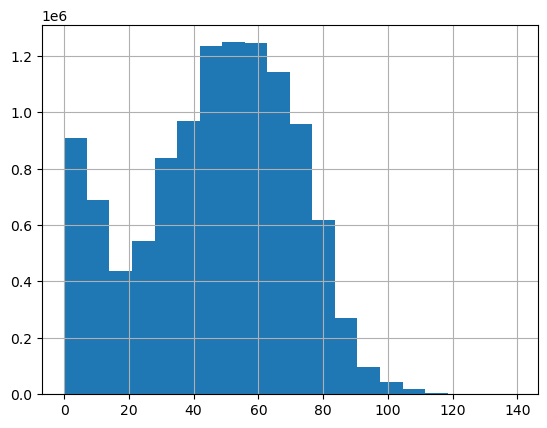

In [43]:
train_dataset['carbon_stock'].hist(bins=20)